In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import collections
import re, string
import sys
import time
import os


In [2]:
import json
import csv

def init_dataset(json) -> tuple[dict, list]:
    ds: dict = {}
    keys = json.keys()
    for k in keys:
        ds[k] = []
    return ds, keys

def read_json(file) -> pd.DataFrame:
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            json_line = json.loads(line.strip())
            if count == 0:
                dataset, keys = init_dataset(json_line)
            for k in keys:
                dataset[k].append(json_line[k])
        return pd.DataFrame(dataset)

def read_csv(file) -> pd.DataFrame:
    dataset = {}
    with open(file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        keys = reader.fieldnames
        for k in keys:
            dataset[k] = []
        for row in reader:
            for k in keys:
                dataset[k].append(row[k])
    return pd.DataFrame(dataset)


### Read In Dataset

In [3]:
#yelp_review = read_json('data/yelp_academic_dataset_review.json')
yelp_review = read_csv('data/yelp_academic_dataset_review.csv')

In [4]:
#yelp_business = read_json('data/yelp_academic_dataset_business.json')
yelp_business = read_csv('data/yelp_academic_dataset_business.csv')

### Sample Dataset

In [5]:
# Sample Data: Restaurants reviewed by karen, the user with the most reviews
# Businesses that are categorized as restaurants
business_restaurant = yelp_business.loc[yelp_business['categories'].str.contains('Restaurant', na=False)]
# Reviews of Restaurant businesses
review_restaurant = yelp_review[yelp_review['business_id'].isin(business_restaurant['business_id'])]
# User with most restaurant reviews
karen = review_restaurant['user_id'].value_counts().index[0]
# Reviews Karen has made of restaurant businesses
review_restaurant_karen = review_restaurant.loc[review_restaurant['user_id'] == karen]
# Restaurant businesses that Karen has reviewed
business_restaurant_karen = business_restaurant[business_restaurant['business_id'].isin(review_restaurant_karen['business_id'])]

### Preprocess Dataset

In [6]:
## Clean Data: remove missing rows and irrelevant columns
df = business_restaurant_karen.set_index('business_id')

# Remove columns with greater than 20% missing fields
mask = df.applymap(lambda x: x =='' or x == 'None').sum()
features = ((mask/len(df)) * 100).map(lambda x: x < 20)


# Remove non-attribute columns (except business_id)
features.loc[~features.index.str.contains('attributes.')] = False
#features.loc['business_id'] = True
dataset = df.loc[:, features]

# Remove rows with missing data
mask = dataset.applymap(lambda x: x == '' or x == 'None')
dataset = dataset.loc[~mask.any(axis=1)]

# Remove all non-boolean columns
mask = dataset.applymap(lambda x : x == 'True' or x == 'False').sum() != 0
#mask.loc['business_id'] = True
#dataset = dataset.set_index('business_id')
dataset = dataset.loc[:, mask].applymap(lambda x: x == 'True')
dataset.shape

(686, 10)

In [7]:
# Transform Data: add targets
df = review_restaurant_karen.set_index('business_id')
df = df.loc[df.index.intersection(dataset.index)]
df = df.astype({'stars':'float'})
dataset['target'] = df.groupby(df.index)['stars'].mean().map(lambda x: x > 3)

In [8]:
# Extract feature set from dataset as numpy array
lamb = lambda x: 1 if x == True else 0
labels = dataset['target'].map(lamb).to_numpy()
feature_set = dataset.drop(['target'], axis=1).applymap(lamb).to_numpy()

### Perform a Principal Component Analysis on Dataset

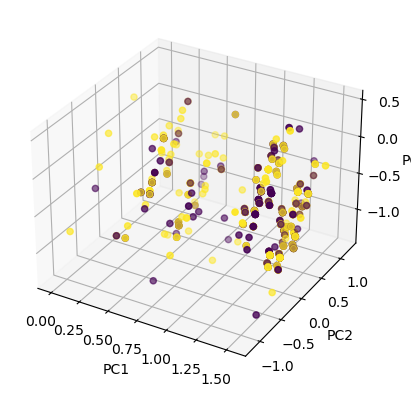

In [11]:
pca_status = 'KENNY'
# Principal Component Analysis
# Calculate eigenvectors and values of covariance matrix
C = np.cov(feature_set.T)
eigen_vals, eigen_vecs = np.linalg.eig(C)
pcts = 100 * eigen_vals / np.sum(eigen_vals)

# Create Feature Matrix to decide which principal components to keep
n_components = 3
sortidx = np.argsort(pcts)
sorted_eigen_vecs = eigen_vecs[sortidx[::-1]]
feature_vec = sorted_eigen_vecs[:n_components + 1]

# Recast Data along axes of principal components
X_pca = (feature_vec @ feature_set.T).T
tmp_df = pd.DataFrame(X_pca)
tmp_df['target'] = labels
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

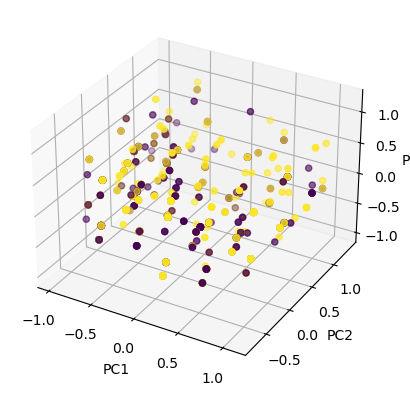

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(feature_set)
X_scaled = feature_set

# Select the top n principal components
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

tmp_df = pd.DataFrame(X_pca)
tmp_df['target'] = labels
pca_status = 'SKLEARN'

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [13]:
tmp_df = dataset.applymap(lamb)
pca_status = 'NONE'

In [14]:
# Delineate between traning and testing set
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(tmp_df, test_size=0.2, random_state=42)
y_train = train_df['target'].to_numpy()
x_train = train_df.drop(['target'], axis=1).to_numpy()

y_test = test_df['target'].to_numpy()
x_test = test_df.drop(['target'], axis=1).to_numpy()
used_pca = pca_status

In [15]:
def calc_stats(pred, true):
    TP = np.sum((true == 1) & (pred == 1))
    TN = np.sum((true == 0) & (pred == 0))
    FP = np.sum((true == 0) & (pred == 1))
    FN = np.sum((true == 1) & (pred == 0))
    accuracy= (TP + TN) / (TP + FN + TN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return accuracy, precision, recall
    
def print_stats(train_pred, train_true, test_pred, test_true):
    tr_acc, tr_prec, tr_rec = calc_stats(train_pred, train_true)
    te_acc, te_prec, te_rec = calc_stats(test_pred, test_true)
    print("PCA = {} | Train : Test".format(used_pca))
    print("Accuracy: {} : {}".format(tr_acc, te_acc))
    print("Precision: {} : {}".format(tr_prec, te_prec))
    print("Recall: {} : {} ".format(tr_rec, te_rec))

### Logistic Regression Classifier using Newton's Method

In [16]:
# hypothesis function... sigmoid function
def g(theta, x):
    return 1 / (1 + np.exp(-x @ theta))

# matrix derivative
def dJ(theta, x, y):
    m, _ = x.shape
    return 1/m* x.T @ (g(theta, x) - y)

# hessian matrix
def HJ(theta, x):
    m, _ = x.shape
    Z = g(theta, x)
    Z = Z*(1-Z)
    return 1/m * Z * x.T @ x

# distance between two vectors
def dist(x, y):
    return np.sum(np.abs(x-y))

In [17]:
class LogisticRegression(object):
    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                theta_0=None, verbose=True):
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        m, n = x.shape
        if self.theta is None:
            self.theta=np.zeros(n)
        for i in range(self.max_iter):
            theta_new = self.theta - np.linalg.inv(HJ(self.theta, x)) @ dJ(self.theta, x, y)
            if dist(theta_new, self.theta) < self.eps:
                self.theta = theta_new
                break
            else:
                self.theta = theta_new

    def predict(self, x):
        return x @ self.theta >= 0

In [18]:
lg = LogisticRegression()
lg.fit(x_train, y_train)
print_stats(lg.predict(x_train), y_train, lg.predict(x_test), y_test)
print("Theta: ", lg.theta)

PCA = NONE | Train : Test
Accuracy: 0.6076642335766423 : 0.6014492753623188
Precision: 0.6358839050131926 : 0.6170212765957447
Recall: 0.7578616352201258 : 0.7532467532467533 
Theta:  [ 0.59714209  0.49508892 -0.042109   -0.08595731  0.51446855 -0.48017102
  0.13016552 -0.64661731 -0.19983955  0.52538337]


### Naive Bayes Model

In [19]:
'''
Naive Bayes Classifier
'''
class NaiveBayes:
    '''
    Naive Bayes Classifier (Bernoulli event model)

    During training, the classifier learns probabilities by counting the
    occurences of feature/label combinations that it finds in the
    training data. During prediction, it uses these counts to
    compute probabilities.
    '''

    def __init__(self, use_laplace_add_one):
        self.label_counts = {}
        self.feature_counts = {}
        self.use_laplace_add_one = use_laplace_add_one # True for Laplace add-one smoothing

    def fit(self, train_features, train_labels):
        '''Training stage - learn from data'''

        self.label_counts[0] = 0
        self.label_counts[1] = 0

        self.label_counts[0] = np.count_nonzero(train_labels == 0)
        self.label_counts[1] = np.count_nonzero(train_labels == 1)

        for row, sample in enumerate(train_features):
            label = train_labels[row]
            for feature, feature_value in enumerate(sample):
                key = (feature, feature_value, label)
                self.feature_counts[key] = self.feature_counts.get(key, 0) + 1

    def predict(self, test_features):
        '''Testing stage - classify new data'''

        preds = np.zeros(test_features.shape[0], dtype=np.uint8)

        tot = self.label_counts[0] + self.label_counts[1]
        p_y0 = self.label_counts[0] / tot
        p_y1 = self.label_counts[1] / tot
        for row, sample in enumerate(test_features):
            p_y0_mid_x = p_y0
            p_y1_mid_x = p_y1
            for feature, feature_value in enumerate(sample):
                #calc prob sample 0
                xi = (feature, feature_value, 0)
                c_xi_and_y0 = self.feature_counts.get(xi, 0)

                #calc prob sample 1 
                xi = (feature, feature_value, 1)
                c_xi_and_y1 = self.feature_counts.get(xi, 0)

                if (self.use_laplace_add_one):
                    p_y0_mid_x *= (c_xi_and_y0 + 1) / (self.label_counts[0] + 2)
                    p_y1_mid_x *= (c_xi_and_y1 + 1) / (self.label_counts[1] + 2)
                else:
                    p_y0_mid_x *= (c_xi_and_y0 / self.label_counts[0])
                    p_y1_mid_x *= (c_xi_and_y1 / self.label_counts[1])

            #calculate argmax
            if (p_y0_mid_x > p_y1_mid_x):
                preds[row] = 0
            else:
                preds[row] = 1 
        return preds


In [20]:
nb = NaiveBayes(True)
nb.fit(x_train, y_train)
print_stats(nb.predict(x_train), y_train, nb.predict(x_test), y_test)

PCA = NONE | Train : Test
Accuracy: 0.6113138686131386 : 0.6014492753623188
Precision: 0.6335877862595419 : 0.6145833333333334
Recall: 0.7830188679245284 : 0.7662337662337663 


### Decision Tree Classifier

In [21]:
import numpy as np

class DecisionTreeClassifier:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.tree) for x in X])

    # Goal: build a tree that recursively paritions feature space such that samples with same labels are grouped together
    # Generate candidate split functions G(Q, theta)
    # Pick split function that minimises impurity
    # use split function to split node
    # repeat for splits until max depth is reached: num_features < min_samples or num_features == 1

    def build_tree(self, X, y, depth=0):
        if y.size == 0:
            return {'type': 'leaf', 'label': None}
        if depth >= self.max_depth or len(set(y)) == 1:
            return {'type': 'leaf', 'label': np.bincount(y).argmax()}

        feature, threshold = self.choose_feature_threshold(X, y)
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        left_subtree = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'type': 'node', 'feature': feature, 'threshold': threshold, 'left': left_subtree, 'right': right_subtree}

    # Generates candidate split functions and picks the best one
    # where best is defined as the one that maximises information gain
    def choose_feature_threshold(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                # looking at feature across businesses
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                if len(left_indices) == 0 or len(right_indices) == 0 or len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                gain = self.calculate_gain(y, left_indices, right_indices)

                if gain > best_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain = gain

        return best_feature, best_threshold

    # information gain is the difference in entropy before and after split
    # G(Q, theta) = H(parent) - (n_left / n_samples) * H(left) - (n_right / n_samples) * H(right)
    def calculate_gain(self, y, left_indices, right_indices):
        left_weight = len(left_indices) / len(y)
        right_weight = len(right_indices) / len(y)
        parent_entropy = self.calculate_entropy(y)
        left_entropy = self.calculate_entropy(y[left_indices])
        right_entropy = self.calculate_entropy(y[right_indices])
        gain = parent_entropy - left_weight * left_entropy - right_weight * right_entropy
        return gain

    # Cross Entropy Loss 
    def calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = np.sum(probabilities * -np.log2(probabilities))
        return entropy

    def traverse_tree(self, x, node):
        if node == None:
            return 0

        if node['type'] == 'leaf':
            return node['label']

        if x[node['feature']] <= node['threshold']:
            return self.traverse_tree(x, node['left'])
        else:
            return self.traverse_tree(x, node['right'])




In [22]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train, y_train)
print_stats(tree_clf.predict(x_train), y_train, tree_clf.predict(x_test), y_test)

PCA = NONE | Train : Test
Accuracy: 0.6405109489051095 : 0.6014492753623188
Precision: 0.6301075268817204 : 0.5932203389830508
Recall: 0.9213836477987422 : 0.9090909090909091 


In [23]:
def print_tree(node, depth=0):
    if node['type'] == 'leaf':
        print('{}[Depth {}] Leaf: {}'.format('  ' * depth, depth, node['label']))
        return

    print('{}[Depth {}] x{} <= {}'.format('  ' * depth, depth, node['feature'], node['threshold']))
    print_tree(node['left'], depth + 1)
    print_tree(node['right'], depth + 1)


print_tree(tree_clf.tree)

[Depth 0] x7 <= 0
  [Depth 1] x1 <= 0
    [Depth 2] x0 <= 0
      [Depth 3] Leaf: 0
      [Depth 3] x9 <= 0
        [Depth 4] x6 <= 0
          [Depth 5] Leaf: 0
          [Depth 5] Leaf: 1
        [Depth 4] x3 <= 0
          [Depth 5] Leaf: 1
          [Depth 5] Leaf: 1
    [Depth 2] x3 <= 0
      [Depth 3] x4 <= 0
        [Depth 4] x9 <= 0
          [Depth 5] Leaf: 1
          [Depth 5] Leaf: 1
        [Depth 4] Leaf: 1
      [Depth 3] Leaf: 1
  [Depth 1] x5 <= 0
    [Depth 2] x3 <= 0
      [Depth 3] x2 <= 0
        [Depth 4] Leaf: 1
        [Depth 4] x8 <= 0
          [Depth 5] Leaf: 1
          [Depth 5] Leaf: 1
      [Depth 3] x9 <= 0
        [Depth 4] x0 <= 0
          [Depth 5] Leaf: 0
          [Depth 5] Leaf: 1
        [Depth 4] x2 <= 0
          [Depth 5] Leaf: 0
          [Depth 5] Leaf: 1
    [Depth 2] x2 <= 0
      [Depth 3] x0 <= 0
        [Depth 4] Leaf: 1
        [Depth 4] x3 <= 0
          [Depth 5] Leaf: 0
          [Depth 5] Leaf: 1
      [Depth 3] x4 <= 0
        [D

### scikit-learn models

In [24]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(x_train, y_train)
print_stats(tree_clf.predict(x_train), y_train, tree_clf.predict(x_test), y_test)

PCA = NONE | Train : Test
Accuracy: 0.7171532846715328 : 0.572463768115942
Precision: 0.7523219814241486 : 0.618421052631579
Recall: 0.7641509433962265 : 0.6103896103896104 
